In [3]:
import pandas as pd
import os
from pathlib import Path


cwd = os.getcwd() # current working directory


wd = Path(cwd).parents[1] # project working directory (2 levels up: exp2_human_aa -> Scripts -> project root)

# Directory containing the CSV files
directory = os.path.join(wd, 'OtherResults', 'binaryTraceOverlaps')

# Path to trial TA conditions file
ta_conditions_path = os.path.join(Path(cwd).parent, 'trialTAConditions.csv')

# Check if directory exists
if not os.path.exists(directory):
    raise FileNotFoundError(f"Directory not found: {directory}\nMake sure you've run the preprocessing scripts first.")

# Check if TA conditions file exists
if not os.path.exists(ta_conditions_path):
    raise FileNotFoundError(f"TA conditions file not found: {ta_conditions_path}")

filename = 'human_AHA_binarytracescores_heur.csv'
filepath = os.path.join(directory, filename)

# Check if input file exists
if not os.path.exists(filepath):
    raise FileNotFoundError(f"Input file not found: {filepath}\nMake sure you've run convert_scores_exp2.py first.")

# Load the data files
scores_df = pd.read_csv(filepath)
ta_conditions_df = pd.read_csv(ta_conditions_path)

# Melt scores_df to long format to associate scores with trials
scores_melted = pd.melt(scores_df, id_vars=['pair', 'agent_type'], value_vars=[str(i) for i in range(7, 25)],
                        var_name='Trial', value_name='Score')

# Convert 'Trial' column to numeric to merge with TA conditions
scores_melted['Trial'] = pd.to_numeric(scores_melted['Trial'])

# Merge melted scores data with TA conditions
merged_df = pd.merge(scores_melted, ta_conditions_df, on='Trial')

# Calculate the average score for each Session, Player, and TACondition
averages_df = merged_df.groupby(['pair', 'agent_type', 'TACondition'])['Score'].mean().reset_index()

# Pivot the table to have TACondition 3, 4, and 5 as separate columns
averages_pivot = averages_df.pivot(index=['pair', 'agent_type'], columns='TACondition', values='Score').reset_index()

# Rename columns for clarity
averages_pivot.columns = ['Pair', 'Agent_Type', 'TACondition_3', 'TACondition_4', 'TACondition_5']

# Save the new DataFrame to a CSV file
output_filename = os.path.join(directory, f'averaged_scores_{os.path.basename(filename)}')
averages_pivot.to_csv(output_filename, index=False)

print(f"Averaged scores saved to '{output_filename}'")

Averaged scores saved to '/Users/mikerichardson/Projects_Python/From-Human-Heuristics-to-Human-AI-Teams/OtherResults/binaryTraceOverlaps/averaged_scores_human_AHA_binarytracescores_heur.csv'


In [4]:
import numpy as np

#take in output_filename and calculate the binary trace overlap scores


#now, all 'Artificial' should get pair 101, 102, 103,....
#all 'Human' should get pair 101, 102, 103,....
#all 'Surrogate' should get pair 401, 402, 403,....

#save the file as binarytraceoverlap.csv

#rename pair column

filename = 'averaged_scores_human_AHA_binarytracescores_heur.csv'
filepath = os.path.join(directory, filename)

# Load the data
all_scores = pd.read_csv(filepath)

all_scores['Pair'] = np.where(all_scores['Agent_Type'] == 'Artificial', all_scores['Pair'] + 101,
                              np.where(all_scores['Agent_Type'] == 'Human', all_scores['Pair'] + 101,
                                       all_scores['Pair'] + 401))

#save the file
all_scores.to_csv(os.path.join(wd,'OtherResults','binaryTraceOverlaps','binarytraceoverlap.csv'), index=False)

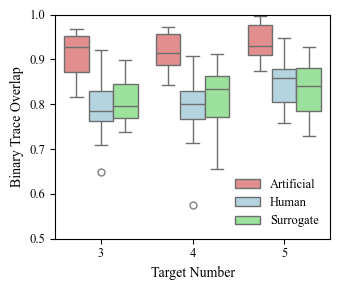

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

filename = 'binarytraceoverlap.csv'
filepath = os.path.join(directory, filename)

# Load the data
data = pd.read_csv(filepath)

# Melt the data to long format for easier plotting
data_melted = pd.melt(data, id_vars=['Pair', 'Agent_Type'], value_vars=['TACondition_3', 'TACondition_4', 'TACondition_5'],
                      var_name='TACondition', value_name='Average_Score')

# Rename TACondition values for better readability
data_melted['TACondition'] = data_melted['TACondition'].str.extract('(\d)').astype(int)

# Create the boxplot with circular outliers
plt.figure(figsize=(3.5, 3))
plt.rcParams['font.family'] = 'Times New Roman'

sns.boxplot(
    x='TACondition', 
    y='Average_Score', 
    hue='Agent_Type', 
    data=data_melted, 
    palette={'Artificial': 'lightcoral', 'Human': 'lightblue', 'Surrogate': 'lightgreen'},
    flierprops=dict(marker='o', markersize=5, markerfacecolor='white', markeredgecolor='grey')  # Change outliers to circles
)

# Customize plot
plt.xlabel('Target Number')
plt.ylabel('Binary Trace Overlap', fontsize=10)
plt.legend(fontsize=9, frameon=False, loc='lower right')  # Keep legend
plt.ylim(0.5, 1.0)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()

# Save the plot
output_filename = os.path.join(directory, 'boxplot_BinaryTrace_AgentType_vs_TargetNumberCondition.png')
plt.savefig(output_filename, dpi=300)

# Show the plot
plt.show()
